# Tutorial 3: Hybrid Modeling

## Objectives

After this tutorial you will be able to:

*   Understand the fundamental concepts and applications of PINNs.
*   Build and apply PINNs to solve physical problems.
*   Explore the advantages and limitations of PINNs compared to traditional methods.

<h2>Table of Contents</h2>

<ol>
    <li>
        <a href="#1">Hybdrid modeling and Physics-informed Neural Networks (PINNs)</a>
    </li>
    <br>
    <li>
        <a href="#2">Building a blackbox neural network</a>
    </li>
    <br>
    <li>
        <a href="#3">Building our first PINN</a>
    </li>
    <br>
    <li>
        <a href="#4">Building a static model using PINN</a>
    </li>
    <br>
    <li>
        <a href="#5">Building a dynamic model using PINN</a>
    </li>
    <br>
</ol>


<hr id="1">
<h2>1. Hybrid modeling and Physics-informed Neural Networks (PINNs)</h2>


### Hybrid Modeling

Imagine trying to understand a complex system, like the human body or a weather system. Data is abundant, but traditional models may not capture all the nuances. This is where **hybrid modeling** comes in.

It's like a team effort, combining different modeling techniques:
- First-principles models: Based on established scientific laws, but can be computationally expensive.
- Data-driven models: Learn from data, but might miss underlying relationships.
  
Hybrid models combine them, leveraging the strengths of both:
- Explainable insights from first principles.
- Data-driven flexibility and adaptation.


### Physics-informed Neural Networks (PINNs)

Now, let's zoom into PINNs, a specific type of hybrid model. Here, the "hybrid" involves data and physics:

- Imagine we have experimental data from an unknown process.
- We also know the underlying physics (e.g. system model equation, physical relations/constraints).
  
A regular neural network learns from data, but might not capture the full picture.  
- It fits the data well within the range of available experimental data.
- It fails to predict outside the data range (grey line).
- It only learns from data, not the underlying physics.

<div style="text-align: center; margin:2rem;">
    <img src="nn-diagram.png">
    <br>
    <small>*source: <a href="https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/">https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/</a></small>
</div>

**PINNs** add the physics equation directly into the training process.  
*Think of it as giving the neural network a "physics lesson". This ensures the network's predictions follow the known laws of physics.*
- PINNs can predict even outside the data range, unlike data-driven models alone.
- They learn from data while respecting the underlying physics.

<div style="text-align: center; margin:2rem;">
    <img src="pinn-diagram.png">
    <br>
    <small>*source: <a href="https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/">https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/</a></small>
</div>


### Example

Consider a simple irreversible first-order reaction as follows:  
$$ A → B $$

The rate of reaction is goverend by the following relation:  
$$ -r_A = -dC_A/dt = kC_A $$

This is a very simple ordinary differential equation and the exact solution is as follows:  
$$ C_A(t) = C_{A0}e ^{-kt} $$

In this lab, we will model the above system (relation) using different models and compare the results:
1. blackbox neural network
2. static PINN
3. dynamic PINN

<hr id="2">
<h2>2. Building a blackbox neural netwwork</h2>


Let's first import necessary libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Now let's create a simple equation to test our network on.

In [2]:
# System model
def exact_solution(c_0, k, x):
    """
    The exact solution to the system model
    y = c_0*exp(-k*x)
    """
    y = c_0 * np.exp(-k * x)
    return y

To train our network, we need some observed/experimental data. So, we will create some data using the above equation and add some noise to it.

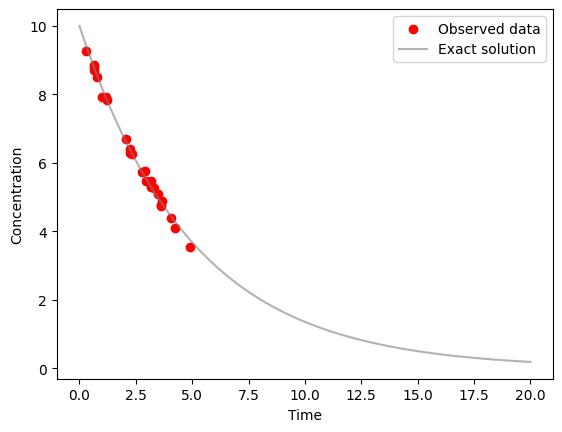

In [4]:
# fix the random seed
torch.manual_seed(12)

# model parameters
c_0 = 10.0      # initial concentration
k = 0.2         # reaction rate constant

# define the experimental range for the independent parameter
x_obs = torch.rand(25).view(-1, 1) * 5

# generate the observed data
y_obs = exact_solution(c_0, k, x_obs)

# add some noise to the observed data
y_obs += 0.1 * torch.randn_like(y_obs)

# define the full range for the independent parameter and the exact solution
x_test = torch.linspace(0, 20, 100).view(-1, 1)
y_exact = exact_solution(c_0, k, x_test)

# plot the data
def plot_observed_data():
    plt.scatter(x_obs, y_obs, label='Observed data', color='red')
    plt.plot(x_test, y_exact, label='Exact solution', color='grey', alpha=0.6)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.show()

plot_observed_data()

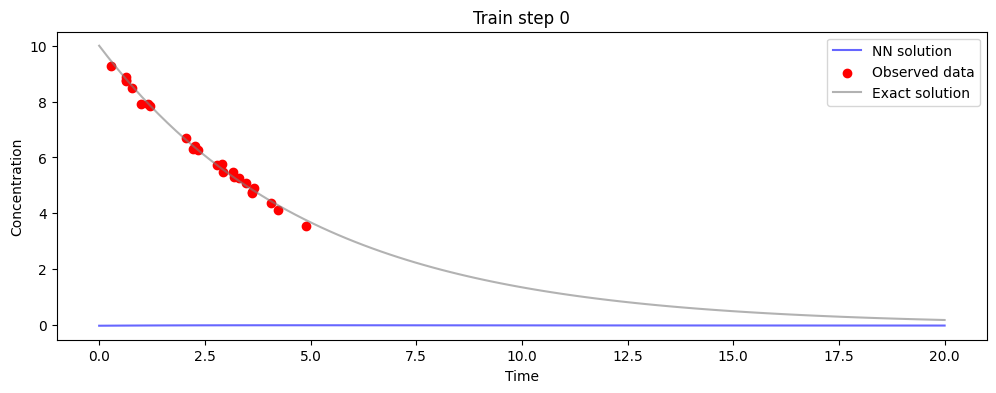

Epoch 0, Loss 42.943443298339844


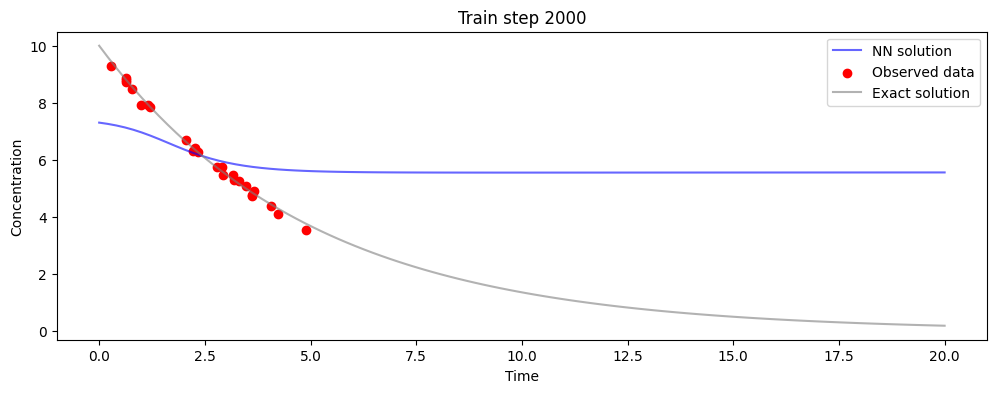

Epoch 2000, Loss 1.2172045707702637


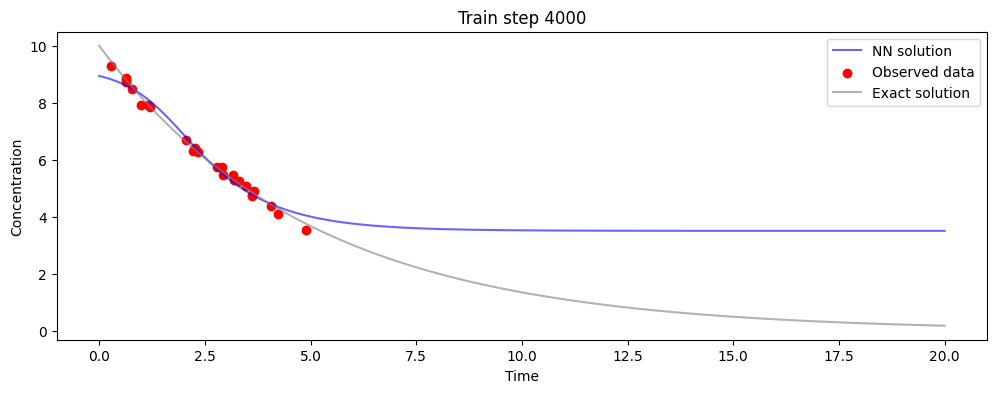

Epoch 4000, Loss 0.04573137313127518


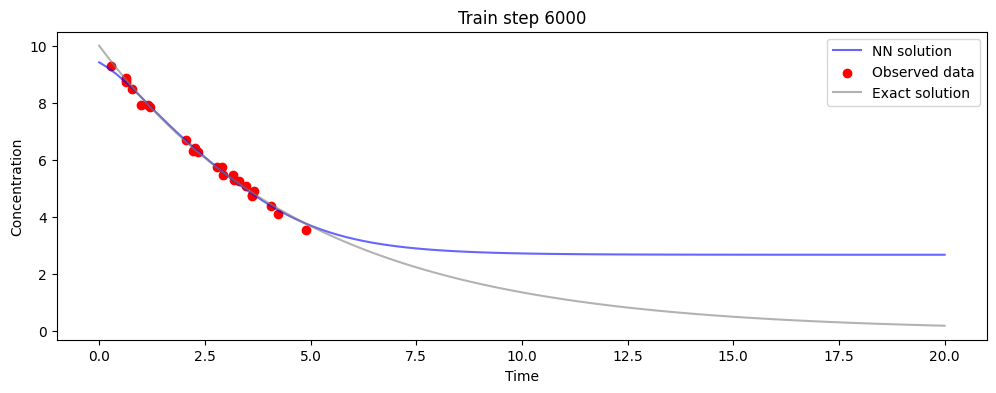

Epoch 6000, Loss 0.013083350844681263


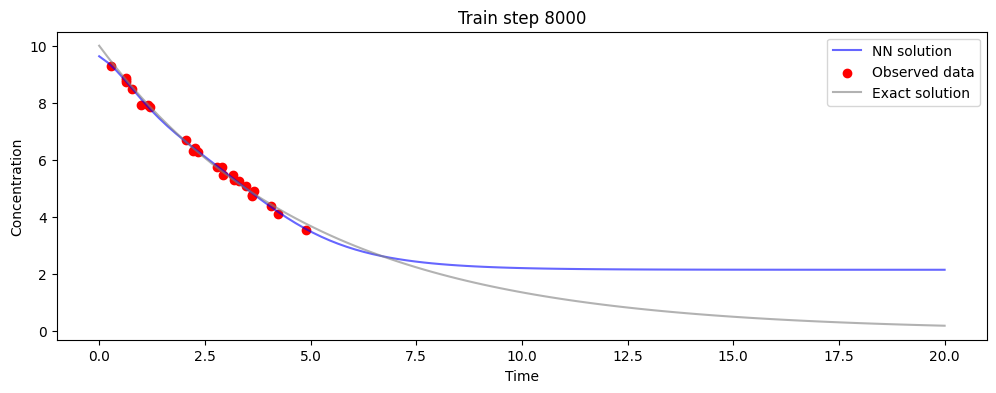

Epoch 8000, Loss 0.007621870841830969


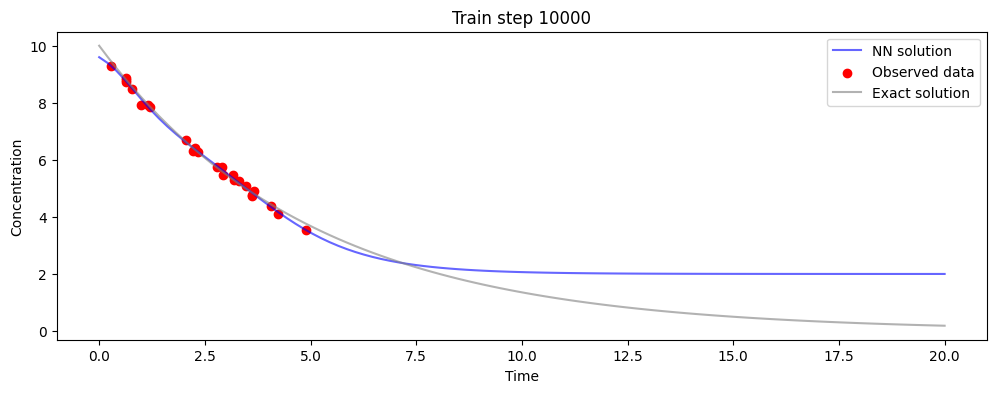

Epoch 10000, Loss 0.007504092529416084


In [6]:
# create neural network class
class NN(nn.Module):
    # define the class constructor
    def __init__(self, n_input, n_output, n_hidden, n_layers, act_fn=nn.Sigmoid()):
        # initialize the super/parent class (nn.Module)
        super().__init__()

        # assign the activation function
        self.act_fn = act_fn

        # create the first hidden layer connected to the inputs
        self.nn_start = nn.Sequential(nn.Linear(n_input, n_hidden), act_fn)

        # create the rest of the hidden layers
        self.nn_hidden = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden, n_hidden), act_fn) for _ in range(n_layers-1)])

        # create the output layer
        self.nn_end = nn.Linear(n_hidden, n_output)

    # define the forward pass of the network
    def forward(self, x):
        x = self.nn_start(x)
        x = self.nn_hidden(x)
        y = self.nn_end(x)
        return y

    # define the fit method
    def fit(self, X, y, n_epochs, lr=0.01):
        # define the optimizer and the loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        # train the model
        for epoch in range(n_epochs+1):
            # 1. reset the gradients back to zero
            optimizer.zero_grad()

            # 2. compute the output prediction
            y_pred = self(X)

            # 3. compute the loss
            loss = loss_fn(y_pred, y)

            # 4. backpropagate the loss
            loss.backward()

            # 5. update the weights
            optimizer.step()

            # plot the result as training progresses
            if epoch % 2000 == 0:
                y_pred = self.forward(x_test).detach()
                plt.figure(figsize=(12, 4))
                plt.title(f'Train step {epoch}')
                plt.plot(x_test[:,0], y_pred[:,0], label='NN solution', color='blue', alpha=0.6)
                plot_observed_data()
                # print the loss
                print(f'Epoch {epoch}, Loss {loss.item()}')


# create a neural network instance
model_nn = NN(1, 1, 10, 2)

# train the NN
model_nn.fit(x_obs, y_obs, 10000, lr=0.001)

<hr id="3">
<h2>3. Building our first PINN</h2>

The model is almost the same. The physical relation is integrated into the model in the loss function as a separate loss term.

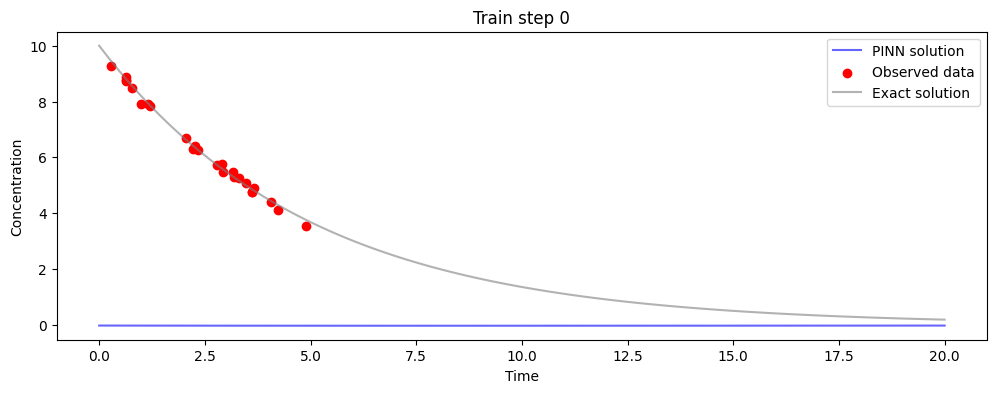

Epoch 0, Loss 56.20588684082031


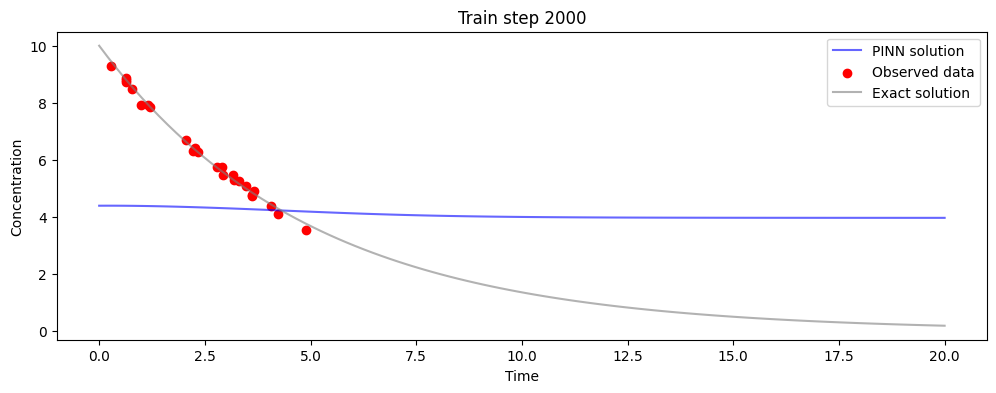

Epoch 2000, Loss 15.133489608764648


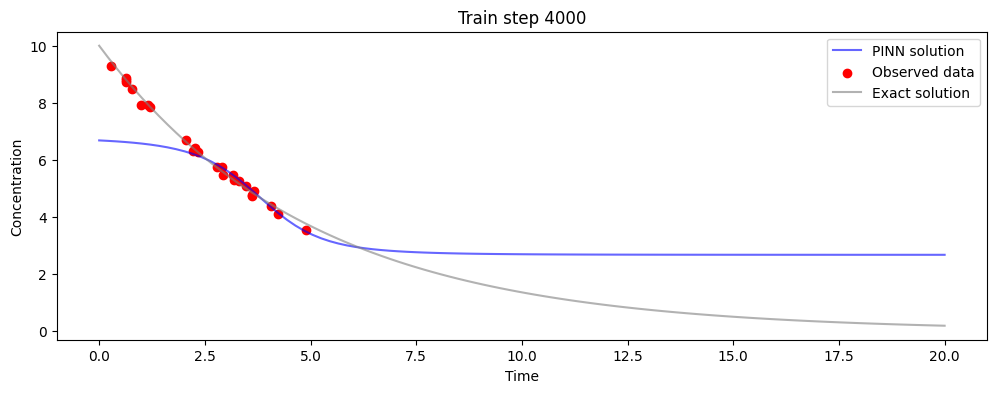

Epoch 4000, Loss 4.008559226989746


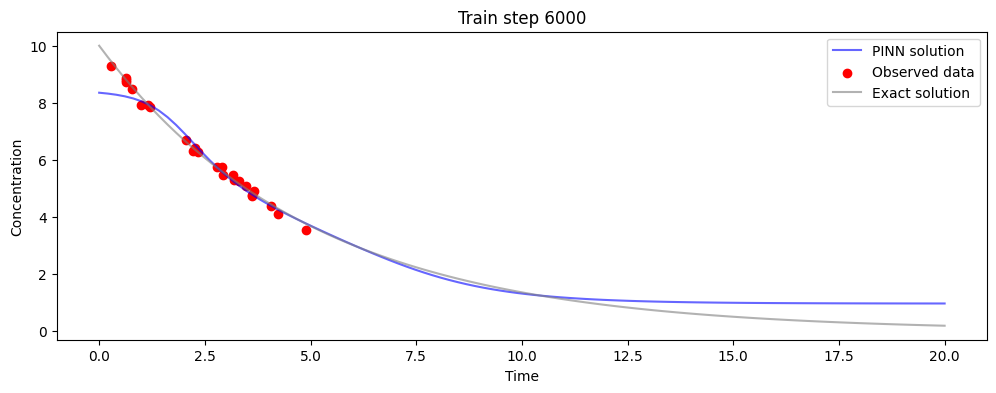

Epoch 6000, Loss 0.292319655418396


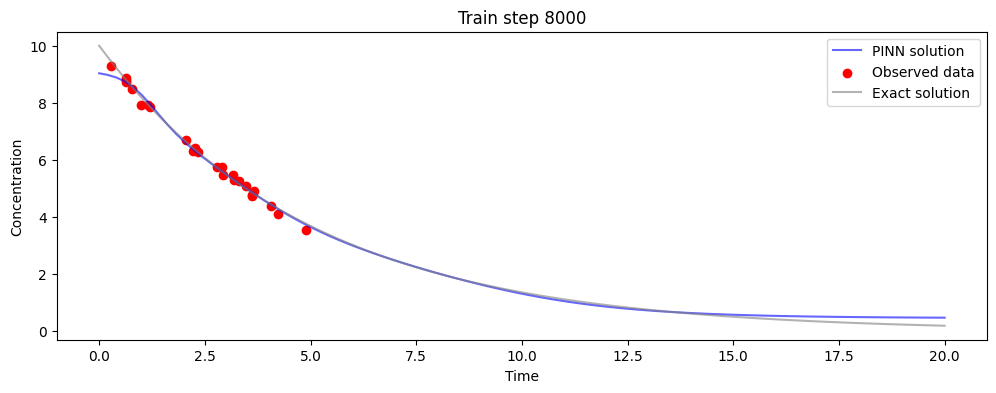

Epoch 8000, Loss 0.04509255290031433


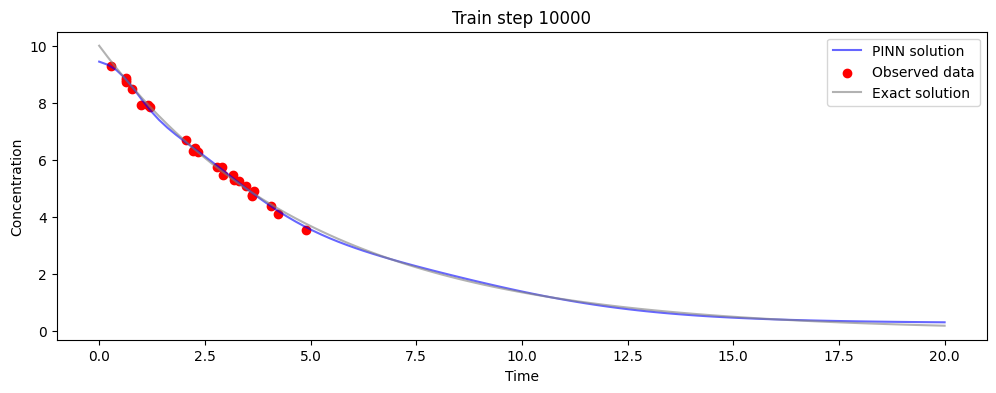

Epoch 10000, Loss 0.01666085608303547


In [8]:
# create neural network class
class PINN(nn.Module):
    # define the class constructor
    def __init__(self, n_input, n_output, n_hidden, n_layers, act_fn=nn.Sigmoid()):
        super().__init__()
        self.act_fn = act_fn

        # create the input layer
        self.nn_start = nn.Sequential(nn.Linear(n_input, n_hidden), act_fn)

        # create the hidden layers
        self.nn_hidden = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden, n_hidden), act_fn) for _ in range(n_layers-1)])

        # create the output layer
        self.nn_end = nn.Linear(n_hidden, n_output)

    # define the forward pass of the network
    def forward(self, x):
        x = self.nn_start(x)
        x = self.nn_hidden(x)
        x = self.nn_end(x)
        return x

    # define the fit method
    def fit(self, X, y, n_epochs, lr=0.01):
        # CHANGE #1: add the physical parameters and the physical data
        x_phys = torch.linspace(0, 20, 100).view(-1, 1).requires_grad_(True)     # very important to set requires_grad=True to compute gradients
        lambda_data = 1
        lambda_phys = 1

        # define the optimizer and the loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        # train the model
        for epoch in range(n_epochs+1):
            # 1. reset the gradients back to zero
            optimizer.zero_grad()

            # 2. compute the output prediction using the trained model
            y_data = self.forward(X)

            # 3.1. compute data loss
            loss_data = loss_fn(y_data, y)

            # CHANGE #2: compute the gradients of the physical loss
            # 3.2. compute physics loss
            y_phys = self.forward(x_phys)
            loss_phys = loss_fn(c_0*torch.exp(-k*x_phys) - y_phys, torch.zeros_like(y_phys))

            # 3.3. compute the total loss
            loss = lambda_data*loss_data + lambda_phys*loss_phys

            # 4. backpropagate the loss
            loss.backward()

            # 5. update the weights
            optimizer.step()

            # plot the result as training progresses
            if epoch % 2000 == 0:
                y_pred = self.forward(x_test).detach()
                plt.figure(figsize=(12, 4))
                plt.title(f'Train step {epoch}')
                plt.plot(x_test[:,0], y_pred[:,0], label='PINN solution', color='blue', alpha=0.6)
                plot_observed_data()

                # print the loss
                print(f'Epoch {epoch}, Loss {loss.item()}')

# create a neural network instance
model_pinn = PINN(1, 1, 3, 2)

# train the NN
model_pinn.fit(x_obs, y_obs, 10000, lr=0.001)

<hr id="4">
<h2>4. Building a static model using PINN</h2>

The above PINN performs well. But we had to know the exact solution which make the network not that useful!

Most of the times the general form of the equation will be known. However, the parameters will be unknown.  

We can program the network to learn those parameters in addition to the network parameters by including it as a `nn.Parameter()`

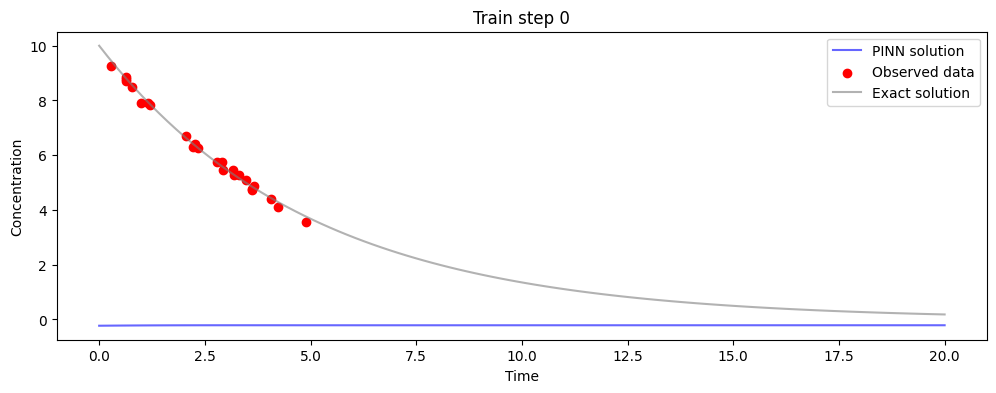

Epoch 0, Loss 50.626708984375


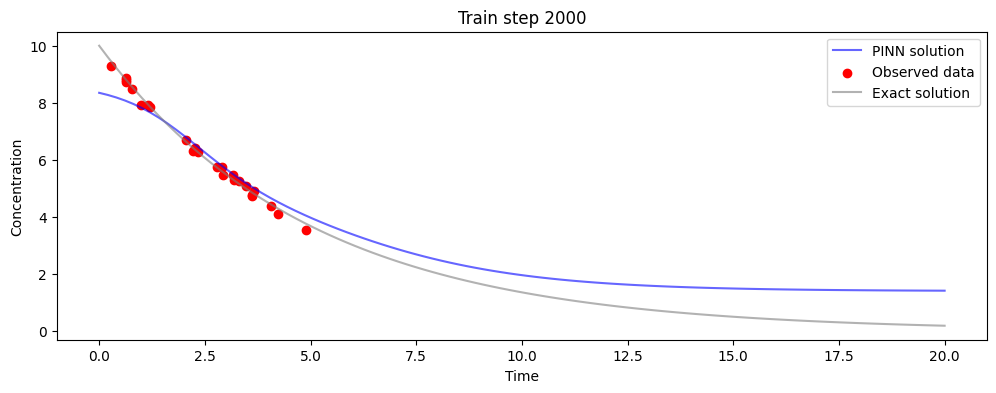

Epoch 2000, Loss 0.5221433639526367


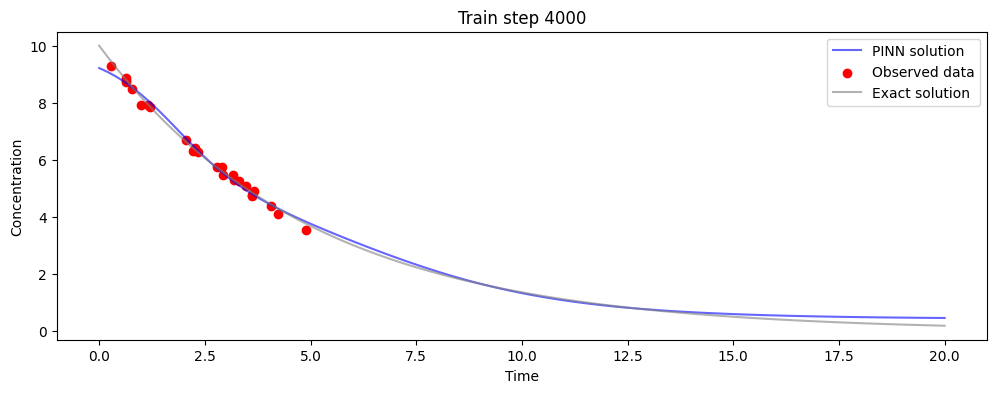

Epoch 4000, Loss 0.04615911841392517


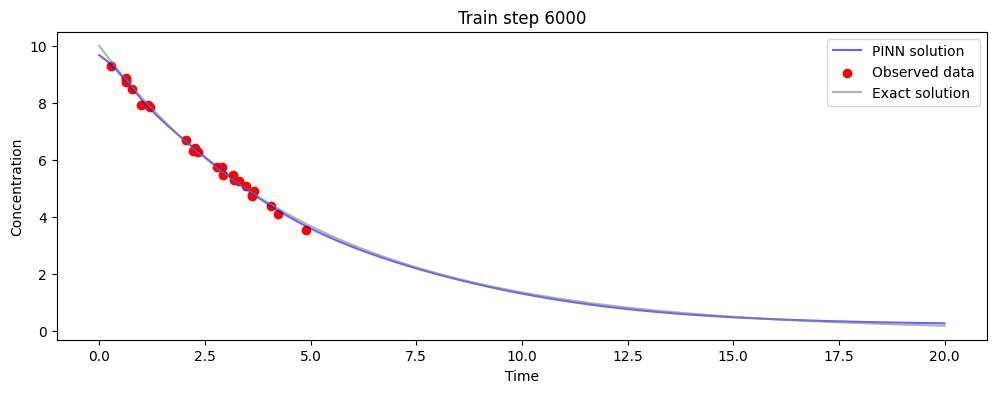

Epoch 6000, Loss 0.011746404692530632


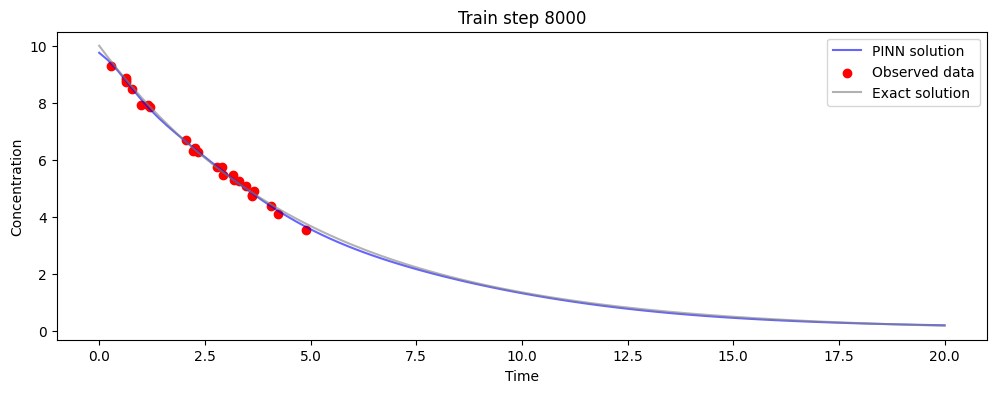

Epoch 8000, Loss 0.010471115820109844


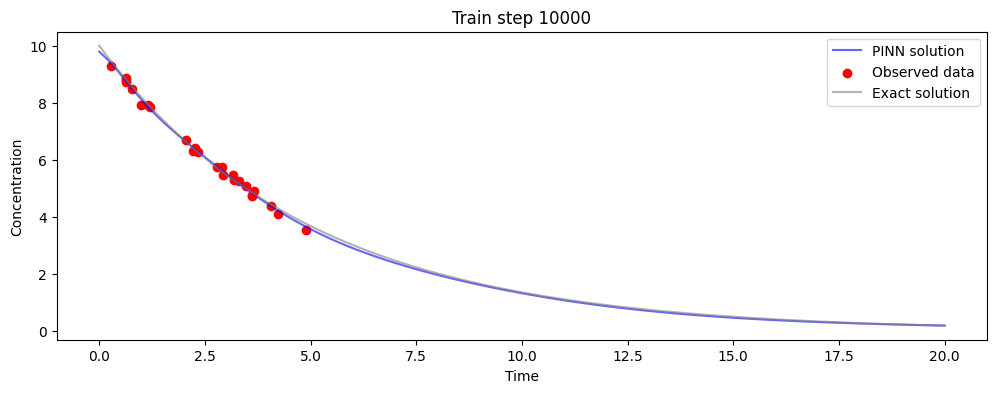

Epoch 10000, Loss 0.010263301432132721


In [9]:
# create neural network class
class PINN(nn.Module):
    # define the class constructor
    def __init__(self, n_input, n_output, n_hidden, n_layers, act_fn=nn.Sigmoid()):
        super().__init__()
        self.act_fn = act_fn

        # create the first hidden layer connected to the inputs
        self.nn_start = nn.Sequential(nn.Linear(n_input, n_hidden), act_fn)

        # create the rest of the hidden layers
        self.nn_hidden = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden, n_hidden), act_fn) for _ in range(n_layers-1)])

        # create the output layer
        self.nn_end = nn.Linear(n_hidden, n_output)

        # CHANGE #1: physical parameters to be learned
        self.k = nn.Parameter(torch.rand(1), requires_grad=True)

    # define the forward pass of the network
    def forward(self, x):
        x = self.nn_start(x)
        x = self.nn_hidden(x)
        x = self.nn_end(x)
        return x

    # define the fit method
    def fit(self, X, y, n_epochs, lr=0.01):
        # CHANGE #2: physical parameters
        x_phys = torch.linspace(0, 20, 100).view(-1, 1).requires_grad_(True)     # very important to set requires_grad=True to compute gradients
        lambda_data = 1
        lambda_phys = 1

        # define the optimizer and the loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        # train the model
        for epoch in range(n_epochs+1):
            # 1. reset the gradients back to zero
            optimizer.zero_grad()

            # 2. compute the output using the trained model
            y_pred = self(X)

            # 3.1. compute data loss
            loss_data = loss_fn(y_pred, y)

            # 3.2. compute physics loss
            y_phys = self.forward(x_phys)
            loss_phys = loss_fn(c_0*torch.exp(-self.k*x_phys), y_phys)

            # 3.3. compute the total loss
            loss = lambda_data*loss_data + lambda_phys*loss_phys

            # 4. backpropagate the loss
            loss.backward()

            # 5. update the weights
            optimizer.step()

            # plot the result as training progresses
            if epoch % 2000 == 0:
                y_pred = self.forward(x_test).detach()
                plt.figure(figsize=(12, 4))
                plt.title(f'Train step {epoch}')
                plt.plot(x_test[:,0], y_pred[:,0], label='PINN solution', color='blue', alpha=0.6)
                plot_observed_data()

                # print the loss
                print(f'Epoch {epoch}, Loss {loss.item()}')

# create a neural network instance
model_pinn = PINN(1, 1, 10, 2)

# train the NN
model_pinn.fit(x_obs, y_obs, 10000, lr=0.001)

Let's see what the learned value of the parameter is:

In [11]:
# print the learned value of the physical parameter (k)
print('Learned value of k:', model_pinn.k.item())

Learned value of k: 0.20354372262954712


<hr id="5">
<h2>4. Building a dynamic model using PINN</h2>

The static model with unknown parameters above is more useful than before. But in simple model equations we can simply perform some data fitting to calculate the physical parameters and directly use the system equation.  

However, in many cases, the system equations will be in the dynamic/differential form which are difficult to solve analytically. This is where PINNs offer their true power!

Let's imagine we have the same system equation above in the differential form and see how that changes our PINN.

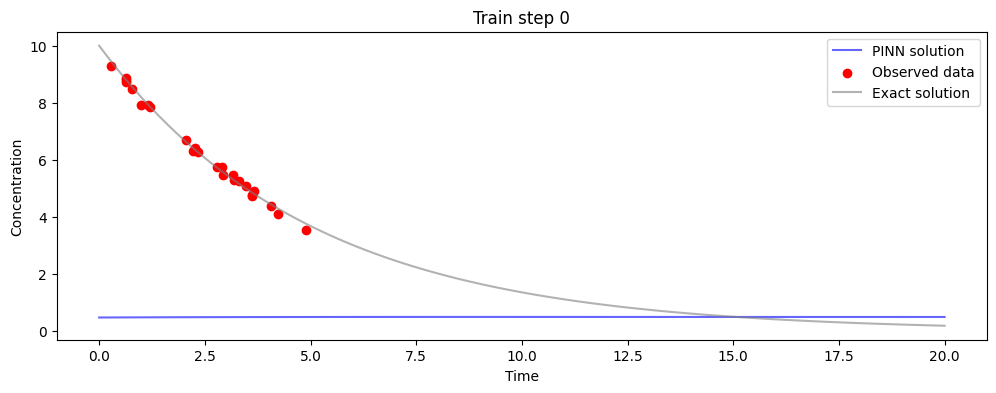

Epoch 0, Loss 962.010009765625


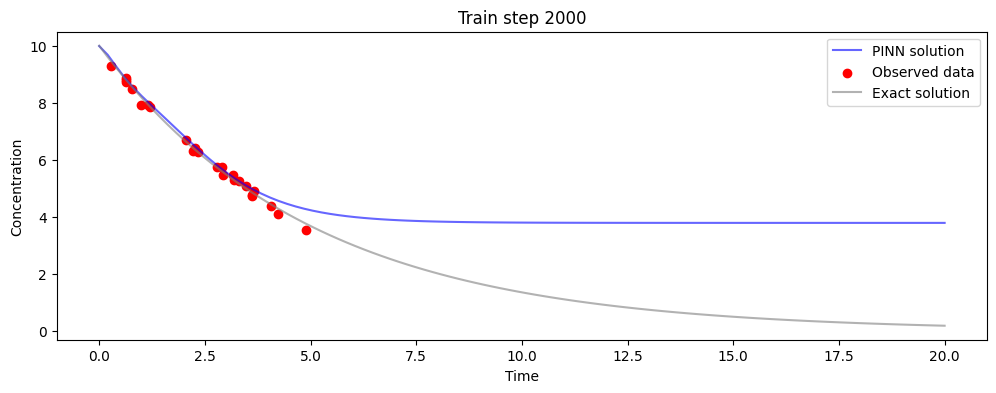

Epoch 2000, Loss 0.4160028100013733


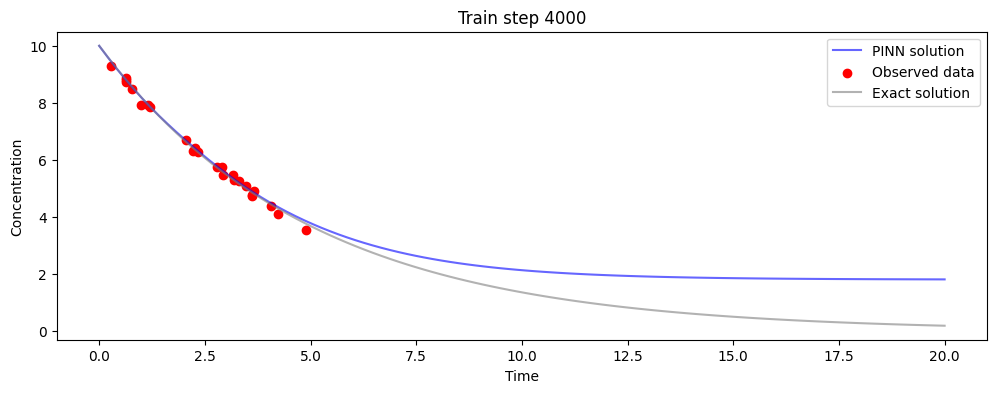

Epoch 4000, Loss 0.12684635818004608


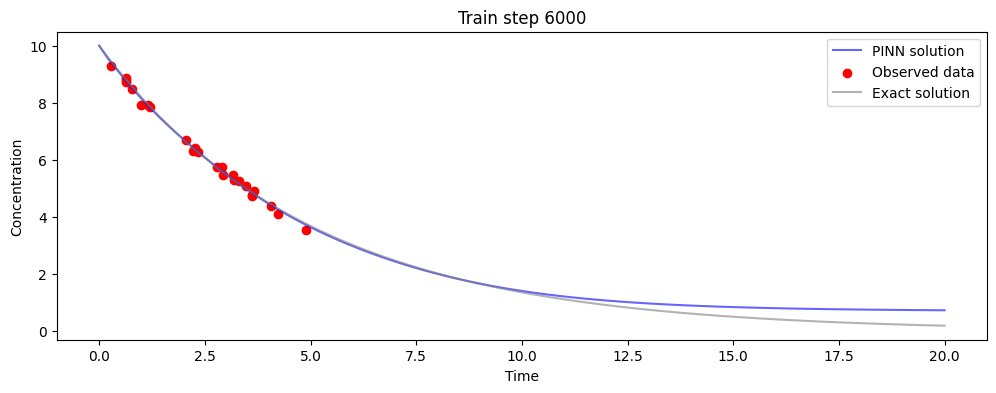

Epoch 6000, Loss 0.02483225427567959


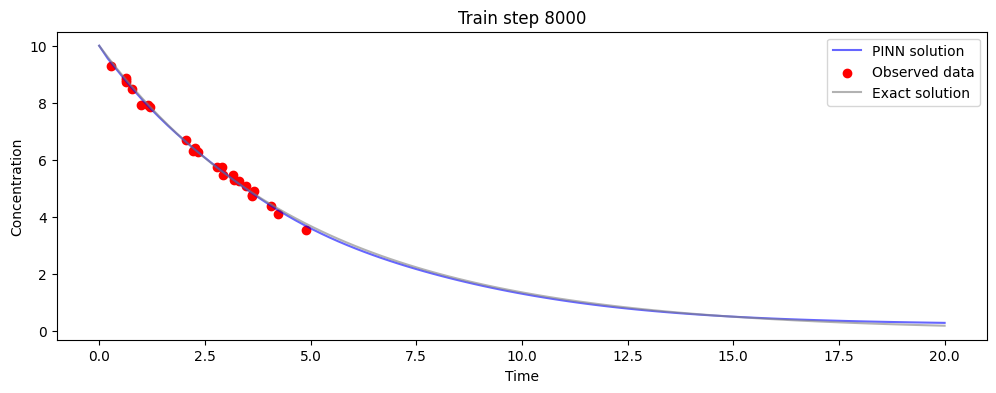

Epoch 8000, Loss 0.011393901892006397


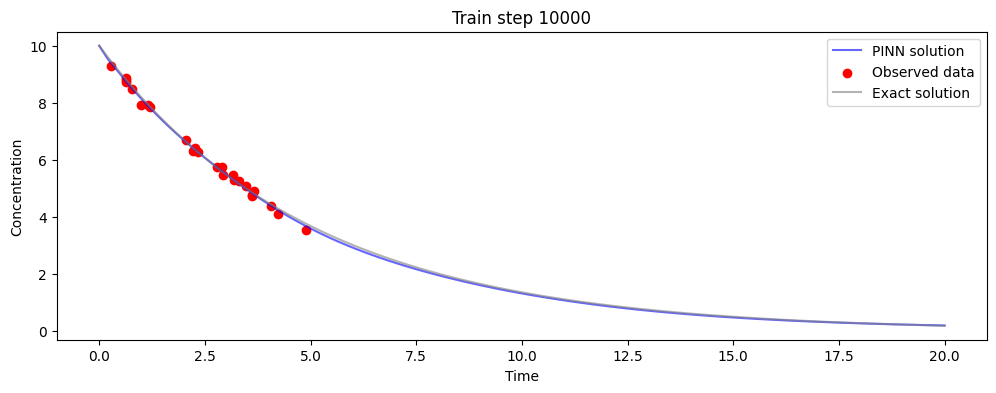

Epoch 10000, Loss 0.010727555491030216


In [15]:
# create neural network class
class PINN(nn.Module):
    # define the class constructor
    def __init__(self, n_input, n_output, n_hidden, n_layers, act_fn=nn.Sigmoid()):
        super().__init__()
        self.act_fn = act_fn

        # create the first hidden layer connected to the inputs
        self.nn_start = nn.Sequential(nn.Linear(n_input, n_hidden), act_fn)

        # create the rest of the hidden layers
        self.nn_hidden = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden, n_hidden), act_fn) for _ in range(n_layers-1)])

        # create the output layer
        self.nn_end = nn.Linear(n_hidden, n_output)

        # CHANGE #1: physical parameters to be learned
        self.k = nn.Parameter(torch.rand(1), requires_grad=True)

    # define the forward pass of the network
    def forward(self, x):
        x = self.nn_start(x)
        x = self.nn_hidden(x)
        x = self.nn_end(x)
        return x

    # define the fit method
    def fit(self, X, y, n_epochs, lr=0.01):
        # CHANGE #2: physical parameters
        x_phys = torch.linspace(0, 20, 100).view(-1, 1).requires_grad_(True)     # very important to set requires_grad=True to compute gradients
        x_init = torch.tensor(0.).view(-1, 1).requires_grad_(True)
        lambda_data = 1
        lambda_phys = 2
        lambda_init = 10

        # define the optimizer and the loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        # train the model
        for epoch in range(n_epochs+1):
            # 1. reset the gradients back to zero
            optimizer.zero_grad()

            # 2. compute the output using the trained model
            y_pred = self.forward(X)

            # 3.1. compute data loss
            loss_data = loss_fn(y_pred, y)

            # CHANGE #3: compute the gradients of the physical loss
            # 3.2. compute physics loss
            y_phys = self.forward(x_phys)
            # compute the derivative of y with respect to x
            # this is done by using the autograd.grad function
            # the 3rd argument is the gradient of y with respect to itself (i.e. the weights of the outputs) which we will set to 1 for our purposes in all cases we consider
            dydx = torch.autograd.grad(y_phys, x_phys, torch.ones_like(y_phys), create_graph=True)[0]
            loss_phys = loss_fn(dydx, -1*self.k*y_phys)

            # CHANGE #4: compute the initial loss
            # 3.3. compute initial loss
            y_init = self.forward(x_init)
            loss_init = loss_fn(y_init, torch.tensor(c_0).view(-1, 1))

            # 3.4. compute the total loss
            loss = lambda_data*loss_data + lambda_phys*loss_phys + lambda_init*loss_init

            # 4. backpropagate the loss
            loss.backward()

            # 5. update the weights
            optimizer.step()

            # plot the result as training progresses
            if epoch % 2000 == 0:
                y_pred = self.forward(x_test).detach()
                plt.figure(figsize=(12, 4))
                plt.title(f'Train step {epoch}')
                plt.plot(x_test[:,0], y_pred[:,0], label='PINN solution', color='blue', alpha=0.6)
                plot_observed_data()

                # print the loss
                print(f'Epoch {epoch}, Loss {loss.item()}')

# create a neural network instance
model_pinn = PINN(1, 1, 10, 2)

# train the NN
model_pinn.fit(x_obs, y_obs, 10000, lr=0.01)

Let's see what the learned value of the parameter is:

In [16]:
# print the learned value of the physical parameter (k)
print('Learned value of k:', model_pinn.k.item())

Learned value of k: 0.2012055367231369


Congratulations! 🎉  
A very powerful tool has been added to your skillset.

<hr style="margin-top: 4rem;">
<h2>Author</h2>

<a href="https://github.com/SamerHany">Samer Hany</a>

<h2>References</h2>

* https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/
* https://www.youtube.com/watch?v=G_hIppUWcsc
* https://medium.com/@theo.wolf/physics-informed-neural-networks-a-simple-tutorial-with-pytorch-f28a890b874a